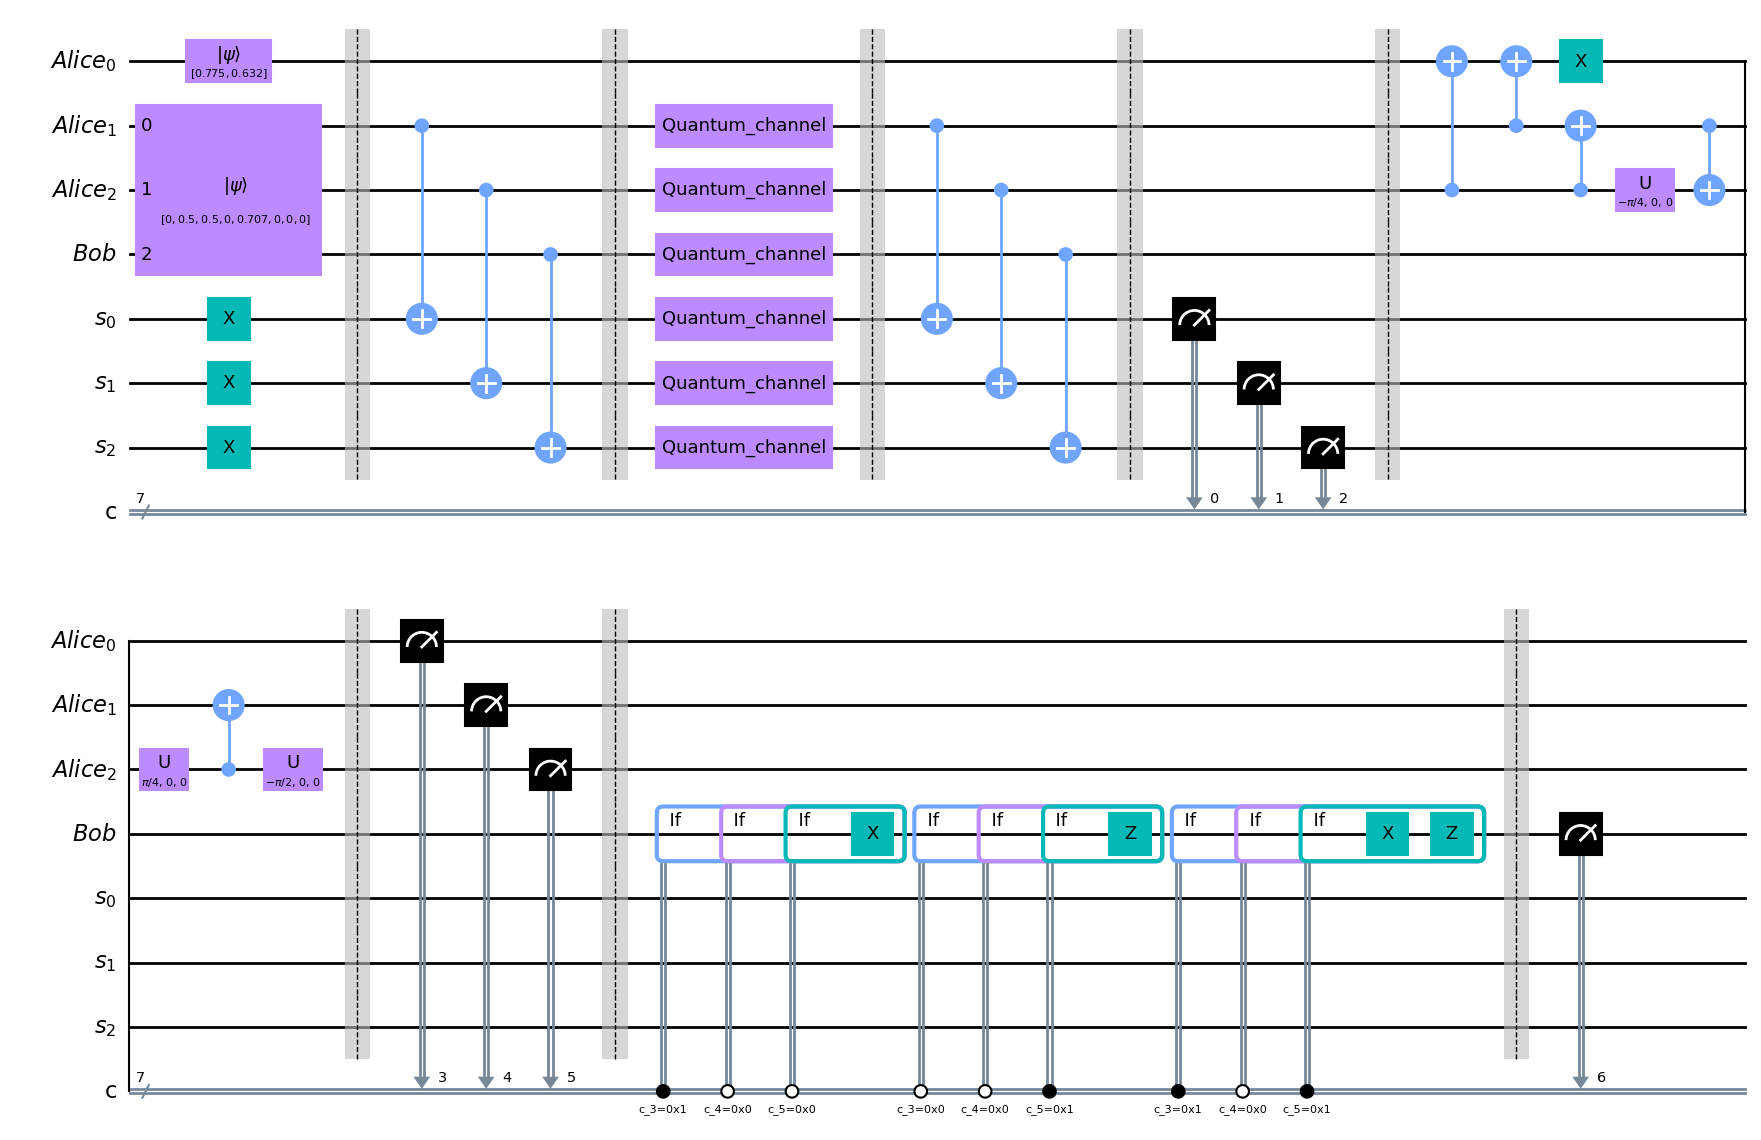

In [23]:
# Import necessary Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile, assemble
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.providers.aer.noise import amplitude_damping_error
from qiskit.quantum_info import Statevector
from qiskit.tools.monitor import job_monitor
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt
from math import pi
# --- Quantum Registers Setup ---
qa = QuantumRegister(3, 'Alice')  # q0: State |ψ⟩ to teleport, q1,q2: Alice's entangled qubit
qb = QuantumRegister(1, 'Bob')    # q2: Bob's entangled qubit
anc = QuantumRegister(3, 's')     # q3, q4,q5: Escort qubits (ancillas)
c = ClassicalRegister(7, 'c')     # Classical bits to store measurement results
qc = QuantumCircuit(qa, qb, anc, c)

# --- Step 1: Prepare an arbitrary qubit state |ψ⟩ on q0 ---
alpha = np.sqrt(0.6)
beta = np.sqrt(1 - alpha**2)
qc.initialize([alpha, beta], [qa[0]])

# --- Step 2: Create the W state 
w_state = [0, 1/2, 1/2, 0, 1/np.sqrt(2), 0, 0, 0] #Since Qiskit stores the qubits in reversed order                                                 
qc.initialize(w_state, [qa[1],qa[2],qb[0]]) #if using initialization we should put the initial value also in reverse order



# --- Step 3: Prepare escort qubits in the |1⟩ state ---
qc.x(anc[0])
qc.x(anc[1])
qc.x(anc[2])
qc.barrier()

# --- Step 4: Pre-noise CNOT operations ---
qc.cx(qa[1], anc[0])   # Alice's qubit controls escort qubit 1
qc.cx(qa[2], anc[1])   # Alice's qubit controls escort qubit 2
qc.cx(qb[0], anc[2])   # Bob's qubit controls escort qubit 3
qc.barrier()

# --- Step 5: Apply Amplitude Damping Channels (noise) ---
# Define noise parameters
lambda1t = 0.2  # damping parameter for Alice
lambda2t = 0.3  # damping parameter for Alice
lambda3t = 0.5  # damping parameter for Bob
r1 = 1 - np.exp(-lambda1t)
r2 = 1 - np.exp(-lambda2t)
r3 = 1 - np.exp(-lambda3t)
# Define amplitude damping errors
error1 = amplitude_damping_error(r1, excited_state_population=0, canonical_kraus=True)
error2 = amplitude_damping_error(r2, excited_state_population=0, canonical_kraus=True)
error3 = amplitude_damping_error(r3, excited_state_population=0, canonical_kraus=True)
# Apply noise to entangled qubits and escort qubits
qc.append(error1, [qa[1]])
qc.append(error1, [anc[0]])
qc.append(error2, [qa[2]])
qc.append(error2, [anc[1]])
qc.append(error3, [qb[0]])
qc.append(error3, [anc[2]])
qc.barrier()

# --- Step 6: Post-noise CNOT operations ---
qc.cx(qa[1], anc[0])   # Alice's qubit controls escort qubit 1
qc.cx(qa[2], anc[1])   # Alice's qubit controls escort qubit 2
qc.cx(qb[0], anc[2])   # Bob's qubit controls escort qubit 3
qc.barrier()

# --- Step 7: Measure the escort qubits ---
qc.measure(anc[0], c[0])
qc.measure(anc[1], c[1])
qc.measure(anc[2], c[2])
qc.barrier()

# --- Step 8: Joint measurement on Alice's qubits (Alice0 and Alice1 and Alice2) ---
qc.cx(2,0)
qc.cx(1,0)
qc.cx(2,1)
qc.u(-pi/4,0,0,2)
qc.cx(1,2)
qc.u(pi/4,0,0,2)
qc.cx(2,1)
qc.x(0)
qc.u(-pi/2,0,0,2)
qc.barrier()

# --- Step 9: Measure Alice's qubits ---
qc.measure(qa[0], c[3])
qc.measure(qa[1], c[4])
qc.measure(qa[2], c[5])
qc.barrier()

# --- Step 10: Apply Conditional Corrections based on Alice's joint measurement ---
# Correction rules:
#   000 -> No correction
#   100 -> Apply X
#   001 -> Apply Z
#   101-> Apply X and Z
with qc.if_test((3, 1)):
    with qc.if_test((4, 0)):
        with qc.if_test((5, 0)):
            qc.x(qb[0]) 

with qc.if_test((3, 0)):
    with qc.if_test((4, 0)):
        with qc.if_test((5, 1)):
            qc.z(qb[0]) 
            
with qc.if_test((3, 1)):
    with qc.if_test((4, 0)):
        with qc.if_test((5, 1)):
            qc.x(qb[0]) 
            qc.z(qb[0]) 
qc.barrier()

# --- Step 11: Final measurement of Bob's qubit ---
qc.measure(qb[0], c[6])

# --- Optional: Draw the final circuit ---
qc.draw('mpl')


In [24]:
Shots_n = 100000  
method = "statevector"
backend = AerSimulator(method="statevector")
job = backend.run(qc, method=method, shots=Shots_n)  # Run the simulation
result = job.result()
counts = result.get_counts()
print(counts)

{'0110110': 326, '1000111': 3676, '0000001': 1629, '0101100': 417, '0000011': 5908, '1000101': 1253, '1001110': 819, '0111101': 305, '0100011': 6041, '0001100': 448, '0100100': 269, '0001101': 1888, '1001011': 6042, '0011001': 194, '1001010': 1263, '0100111': 5432, '0000111': 5553, '0110010': 206, '0101110': 1264, '0000101': 1117, '0100000': 371, '1001111': 3720, '1100111': 3597, '0010001': 311, '1101101': 1305, '0110001': 293, '0000110': 688, '0101111': 5463, '1101001': 2077, '1101011': 5922, '0010101': 489, '1101000': 564, '0111110': 183, '1001101': 1300, '0100010': 1019, '1001100': 415, '0001110': 1258, '0100101': 1148, '0000010': 1002, '0110101': 490, '1000100': 287, '1101111': 3691, '0100001': 1536, '1001001': 2078, '1100101': 1286, '1101100': 438, '0010110': 295, '0000100': 303, '0101101': 2024, '0111010': 127, '0100110': 730, '0001111': 5441, '1100100': 267, '0011010': 139, '0000000': 373, '1000110': 830, '0011110': 206, '1101110': 816, '1101010': 1328, '0111001': 215, '1001000'

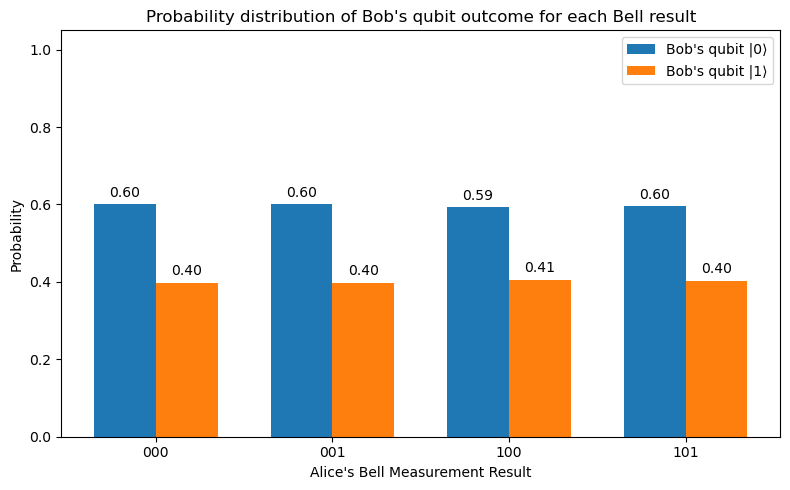

----------------------------------------------------
Total Success Probability (Escort qubits = '111') = 0.3657
Mathematical Probability  = 0.3679
----------------------------------------------------
(Fidelity for each Bell measurement outcome:)
Bell result 000: Fidelity = 1.0000
Bell result 001: Fidelity = 1.0000
Bell result 100: Fidelity = 1.0000
Bell result 101: Fidelity = 1.0000


In [25]:
# --- Analyze Results ---

success, fail = 0, 0
Bell_states = {}

# Step 1: Filter outcomes where all escort qubits were measured as '1'
for outcome, count in counts.items():
    if outcome[-1] == '1' and outcome[-2] == '1' and outcome[-3] == '1':
        success += count
        Bell_states[outcome] = Bell_states.get(outcome, 0) + count
    else:
        fail += count

total = success + fail

# Step 2: Classify outcomes based only on the valid joined measurement results
Bell_measurement_results = {'000': {}, '001': {}, '100': {}, '101': {}}

for outcome, count in Bell_states.items():
    # c5 (Alice[2]), c4 (Alice[1]), c3 (Alice[0])
    bell_result = outcome[-4] + outcome[-5] + outcome[-6]
    output_bit = outcome[-7]  # Bob's qubit measurement (c6)

    if bell_result in Bell_measurement_results:
        if output_bit in Bell_measurement_results[bell_result]:
            Bell_measurement_results[bell_result][output_bit] += count
        else:
            Bell_measurement_results[bell_result][output_bit] = count

# Step 3: Prepare data for plotting
labels = []
probs_0 = []
probs_1 = []

for bell_result in ['000', '001', '100', '101']:
    result_counts = Bell_measurement_results[bell_result]
    total_counts = sum(result_counts.values())
    if total_counts > 0:
        prob0 = result_counts.get('0', 0) / total_counts
        prob1 = result_counts.get('1', 0) / total_counts
    else:
        prob0, prob1 = 0, 0

    labels.append(bell_result)
    probs_0.append(prob0)
    probs_1.append(prob1)

# Step 4: Plot grouped bar chart
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, probs_0, width, label="Bob's qubit |0⟩")
rects2 = ax.bar(x + width/2, probs_1, width, label="Bob's qubit |1⟩")

# Labels and title
ax.set_ylabel('Probability')
ax.set_xlabel('Alice\'s Bell Measurement Result')
ax.set_title('Probability distribution of Bob\'s qubit outcome for each Bell result')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add probability numbers on top of bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

# Step 5: Print success probability
print('----------------------------------------------------')
print(f"Total Success Probability (Escort qubits = '111') = {success / total:.4f}")
print(f"Mathematical Probability  = {(1 - r1) * (1 - r2) * (1 - r3):.4f}")

# Step 6: Calculate and print fidelity for each Bell result
print('----------------------------------------------------')
print("(Fidelity for each Bell measurement outcome:)")

for bell_result in ['000', '001', '100', '101']:
    result_counts = Bell_measurement_results[bell_result]
    total_counts = sum(result_counts.values())
    if total_counts > 0:
        p0 = result_counts.get('0', 0) / total_counts
        p1 = result_counts.get('1', 0) / total_counts

        # Fidelity formula
        fidelity = (alpha**2) * p0 + (beta**2) * p1 + 2 * alpha * beta * np.sqrt(p0 * p1)
        print(f"Bell result {bell_result}: Fidelity = {fidelity:.4f}")
    else:
        print(f"Bell result {bell_result}: No successful counts (fidelity undefined)")
